In [1]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolTransforms

# Define functions for transformations
def translate(x, y, z):
    return np.array([[1, 0, 0, x],
                     [0, 1, 0, y],
                     [0, 0, 1, z],
                     [0, 0, 0, 1]], dtype=np.double)

def rotation_x(angle_degree):
    angle_radian = angle_degree * np.pi / 180
    return np.array([[1, 0, 0, 0],
                     [0, np.cos(angle_radian), -np.sin(angle_radian), 0],
                     [0, np.sin(angle_radian), np.cos(angle_radian), 0],
                     [0, 0, 0, 1]], dtype=np.double)

# Set SMILES for first molecule (benzene)
first_smiles = "c1ccccc1"

# Convert to RDKit molecule
first_mol = Chem.MolFromSmiles(first_smiles)

# Add hydrogens
first_mol = Chem.AddHs(first_mol)

# Generate a 3D conformer
AllChem.EmbedMolecule(first_mol)

# Optimize molecule
AllChem.MMFFOptimizeMolecule(first_mol)

# Orient the molecule
Chem.rdMolTransforms.CanonicalizeConformer(first_mol.GetConformer())

# Set SMILES for second molecule (benzene)
second_smiles = "C1(=C(C(=C(C(=C1F)F)F)F)F)F"

# Convert to RDKit molecule
second_mol = Chem.MolFromSmiles(second_smiles)

# Add hydrogens
second_mol = Chem.AddHs(second_mol)

# Generate a 3D conformer
AllChem.EmbedMolecule(second_mol)

# Optimize molecule
AllChem.MMFFOptimizeMolecule(second_mol)

# Orient the second molecule based on the first one
center = Chem.rdMolTransforms.ComputeCentroid(first_mol.GetConformer())
Chem.rdMolTransforms.CanonicalizeConformer(second_mol.GetConformer(), center=center)

# Apply transformations: Rotate both benzene rings 90 degrees around the X-axis
rdMolTransforms.TransformConformer(first_mol.GetConformer(0), rotation_x(90))
rdMolTransforms.TransformConformer(second_mol.GetConformer(0), rotation_x(90))

# Translate the second benzene ring 4 angstroms in the Y direction
rdMolTransforms.TransformConformer(second_mol.GetConformer(0), translate(0, 4, 0))

# Combine the two molecules
dimer = Chem.CombineMols(first_mol, second_mol)

# Save the molecule in XYZ format 
Chem.MolToXYZFile(dimer, "florodimer_4.xyz")


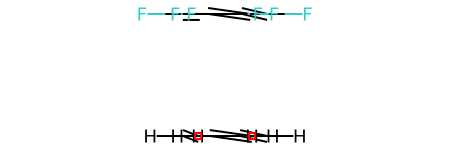

In [2]:
dimer

In [3]:
# import 
from pyscf import gto, scf


mol = gto.M(atom="florodimer_4.xyz")

# set basis set
mol.basis = "6-31G*"

# set the functional
mf = mol.KS()
mf.xc = 'b3lyp'

# run energy calculations
mf.kernel() 

/Users/rpatel/miniconda3/lib/python3.12/site-packages/pyscf/dft/libxc.py:1110: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


converged SCF energy = -1045.47236207245


-1045.4723620724549

In [4]:
# total number of electrons
n = mol.tot_electrons()
n

132

In [5]:
# display all orbitals
mf.mo_energy

array([-24.43787827, -24.43786638, -24.43786311, -24.4378348 ,
       -24.4378317 , -24.43779284, -10.08104242, -10.08069891,
       -10.08069779, -10.08007597, -10.08007484, -10.07958681,
       -10.00845161, -10.00811039, -10.00810773, -10.00750747,
       -10.00750483, -10.00703943,  -1.16344786,  -1.15563325,
        -1.15563036,  -1.14121867,  -1.1412157 ,  -1.13404057,
        -0.82509419,  -0.8104616 ,  -0.70454084,  -0.70453876,
        -0.69959096,  -0.69958836,  -0.57333981,  -0.57333927,
        -0.56331298,  -0.56331218,  -0.50741185,  -0.48773451,
        -0.46245767,  -0.43206756,  -0.42732807,  -0.42430164,
        -0.40621519,  -0.40621198,  -0.39862013,  -0.384654  ,
        -0.3846522 ,  -0.38205815,  -0.38205425,  -0.3590942 ,
        -0.35909252,  -0.31879867,  -0.30137488,  -0.30137449,
        -0.30061513,  -0.3006119 ,  -0.28759535,  -0.26903715,
        -0.26903665,  -0.26397209,  -0.22940496,  -0.22940438,
        -0.19875112,  -0.19862058,  -0.19861972,  -0.19

In [6]:
# HOMO is n/2 orbital. But python index starts from 0, so need to substract -1
homo = mf.mo_energy[int(n/2) - 1]
homo

-0.13526247900424324

In [7]:
# the unit of energy is Hartree. To convert to eV
homo1=homo * 27.2114
homo1

-3.6806814211760646

In [8]:
lumo = 0.08867119
lumo

0.08867119

In [9]:
lumo1=lumo*27.2114
lumo1

2.412867219566

In [10]:
gap = lumo1-homo1
gap

6.093548640742064

In [11]:
# import the definitions
from pyscf.tools import molden

# we will write the surface to molden files
with open('florobenzene_dimer_4.molden', 'w') as f1:
    molden.header(mol, f1)
    molden.orbital_coeff(mol, f1, mf.mo_coeff, ene=mf.mo_energy, occ=mf.mo_occ)